## Mount Google Drive

In [1]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Set Project Directory and Change Path

In [2]:
import os

project_dir = '/content/drive/MyDrive/Skin-Cancer-Detection'
os.chdir(project_dir)

## Copy Images and Metadata to Local Colab Disk

In [3]:
import shutil

local_data_dir = '/content/data'
drive_data_dir = os.path.join(project_dir, 'data')

# Copy image folder
if not os.path.exists(f"{local_data_dir}/HAM10000"):
    os.makedirs(local_data_dir, exist_ok=True)
    print("Copying HAM10000 images to local disk...")
    shutil.copytree(os.path.join(drive_data_dir, 'HAM10000'), f"{local_data_dir}/HAM10000")
else:
    print("HAM10000 images already copied.")

# Copy CSVs
for fn in ['train_meta.csv', 'val_meta.csv', 'test_meta.csv']:
    src = os.path.join(drive_data_dir, fn)
    dst = os.path.join(local_data_dir, fn)
    if not os.path.exists(dst):
        shutil.copy(src, dst)
        print(f"Copied {fn} to local disk.")
    else:
        print(f"{fn} already exists in local disk.")

Copying HAM10000 images to local disk...
Copied train_meta.csv to local disk.
Copied val_meta.csv to local disk.
Copied test_meta.csv to local disk.


## Imports and Helper Functions

### Imports

In [3]:
import pandas as pd
import numpy as np
import cv2
import albumentations as A
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.utils import Sequence
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications import (
    EfficientNetB4, DenseNet201, ResNet101, InceptionV3, Xception
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import tensorflow as tf

### Helper Functions

In [4]:
def gray_world(img, **kwargs):
    img = img.astype(np.float32)
    avgR, avgG, avgB = np.mean(img[:,:,0]), np.mean(img[:,:,1]), np.mean(img[:,:,2])
    avgGray = (avgR + avgG + avgB) / 3
    img[:,:,0] *= avgGray / (avgR + 1e-8)
    img[:,:,1] *= avgGray / (avgG + 1e-8)
    img[:,:,2] *= avgGray / (avgB + 1e-8)
    return np.clip(img, 0, 255).astype(np.uint8)

def get_train_aug(img_size=224):
    return A.Compose([
        A.Lambda(image=gray_world, p=1.0),
        A.Resize(img_size, img_size),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.Rotate(limit=180, p=0.7),
        A.Affine(
            scale=(0.9, 1.1),
            translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
            shear=(-8, 8),
            border_mode=cv2.BORDER_REFLECT_101, p=0.5
        ),
        A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05, p=0.6),
        A.RandomCrop(img_size, img_size, p=0.5)
    ])

def get_val_aug(img_size=224):
    return A.Compose([
        A.Lambda(image=gray_world, p=1.0),
        A.Resize(height=img_size, width=img_size)
    ])

## Custom Dataset Class

In [5]:
class HAM10000Dataset(Sequence):
    def __init__(self, df, img_dir, img_size=224, augment_fn=None, batch_size=8, shuffle=True, label_encoder=None, **kwargs):
        super().__init__(**kwargs)
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.img_size = img_size
        self.augment_fn = augment_fn
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.label_encoder = label_encoder or LabelEncoder().fit(df['dx'])
        self.indices = np.arange(len(self.df))
        self.on_epoch_end()

    def __len__(self): return int(np.ceil(len(self.df) / self.batch_size))

    def __getitem__(self, idx):
        inds = self.indices[idx*self.batch_size:(idx+1)*self.batch_size]
        batch_df = self.df.iloc[inds]
        imgs, labels = [], []
        for _, row in batch_df.iterrows():
            img_path = f"{self.img_dir}/{row['image_id']}.jpg"
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            if self.augment_fn:
                img = self.augment_fn(image=img)['image']
            img = img.astype(np.float32) / 255.0
            imgs.append(np.array(img, dtype=np.float32))
            labels.append(row['dx'])
        X = np.stack(imgs).astype(np.float32)
        y = self.label_encoder.transform(labels)
        return X, y

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

## Load Splits and Compute Class Weights

In [6]:
train_df = pd.read_csv("/content/data/train_meta.csv")
val_df = pd.read_csv("/content/data/val_meta.csv")

In [7]:
label_encoder = LabelEncoder().fit(train_df['dx'])
classes = sorted(train_df['dx'].unique())
class_indices = {c: i for i, c in enumerate(classes)}
class_weights = compute_class_weight(class_weight='balanced', classes=np.array(classes), y=train_df['dx'])
class_weights_dict = {class_indices[c]: w for c, w in zip(classes, class_weights)}

### Define Custom Weighted Loss

In [8]:
@tf.keras.utils.register_keras_serializable()
def weighted_loss(class_weights):
    weights = tf.constant([class_weights[i] for i in range(len(class_weights))], dtype=tf.float32)
    def loss_fn(y_true, y_pred):
        y_true_int = tf.cast(y_true, tf.int32)
        sample_weights = tf.gather(weights, y_true_int)
        ce = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
        return tf.reduce_mean(ce * sample_weights)
    return loss_fn

## Model Configurations

In [9]:
from tensorflow.keras.applications import EfficientNetB4, DenseNet201, ResNet101, InceptionV3, Xception

def build_model(backbone_fn, input_shape=(224,224,3), n_classes=7, pretrained='imagenet'):
    input_tensor = Input(shape=input_shape)
    base_model = backbone_fn(include_top=False, weights=pretrained, input_tensor=input_tensor)
    x = GlobalAveragePooling2D()(base_model.output)
    output = Dense(n_classes, activation="softmax")(x)
    return Model(inputs=input_tensor, outputs=output)

In [10]:
all_models = {
    "efficientnetb4": {
        "fn": lambda: build_model(
            EfficientNetB4,
            input_shape=(380, 380, 3),
            n_classes=len(label_encoder.classes_)
        ),
        "input_shape": (380, 380, 3),
        "img_size": 380,
        "batch_size": 8,
        "lr": 5e-5
    },
    "densenet201": {
        "fn": lambda: build_model(
            DenseNet201,
            input_shape=(224, 224, 3),
            n_classes=len(label_encoder.classes_)
        ),
        "input_shape": (224, 224, 3),
        "img_size": 224,
        "batch_size": 8,
        "lr": 1e-4
    },
    "resnet101": {
        "fn": lambda: build_model(
            ResNet101,
            input_shape=(224, 224, 3),
            n_classes=len(label_encoder.classes_)
        ),
        "input_shape": (224, 224, 3),
        "img_size": 224,
        "batch_size": 8,
        "lr": 1e-4
    },
    "inceptionv3": {
        "fn": lambda: build_model(
            InceptionV3,
            input_shape=(299, 299, 3),
            n_classes=len(label_encoder.classes_)
        ),
        "input_shape": (299, 299, 3),
        "img_size": 299,
        "batch_size": 8,
        "lr": 1e-4
    },
    "xception": {
        "fn": lambda: build_model(
            Xception,
            input_shape=(299, 299, 3),
            n_classes=len(label_encoder.classes_)
        ),
        "input_shape": (299, 299, 3),
        "img_size": 299,
        "batch_size": 8,
        "lr": 1e-4
    }
}

## Training Loop for All Models

In [11]:
os.makedirs("/content/models", exist_ok=True)

In [12]:
all_histories = {}

for name, mcfg in all_models.items():
    print(f"\n--- Training {name} ---")

    img_size = mcfg["img_size"]
    batch_size = mcfg["batch_size"]

    train_dataset = HAM10000Dataset(
        train_df, "/content/data/HAM10000",
        img_size=img_size,
        augment_fn=get_train_aug(img_size),
        batch_size=batch_size, shuffle=True, label_encoder=label_encoder
    )
    val_dataset = HAM10000Dataset(
        val_df, "/content/data/HAM10000",
        img_size=img_size,
        augment_fn=get_val_aug(img_size),
        batch_size=batch_size, shuffle=False, label_encoder=label_encoder
    )
    model = mcfg["fn"]()
    model.compile(
        optimizer=Adam(learning_rate=mcfg['lr']),
        loss=weighted_loss(class_weights_dict),
        metrics=["accuracy"]
    )
    callbacks = [
        ModelCheckpoint(f"/content/models/{name}_best_model.keras", monitor="val_loss", mode="min", save_best_only=True, verbose=1),
        ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-7, verbose=1),
        EarlyStopping(monitor="val_loss", patience=7, verbose=1, restore_best_weights=True)
    ]
    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=60,
        callbacks=callbacks
    )

    all_histories[name] = history.history


--- Training efficientnetb4 ---
Epoch 1/60
878/878 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.3517 - loss: 1.6029
Epoch 1: val_loss improved from inf to 1.76542, saving model to /content/models/efficientnetb4_best_model.keras
878/878 ━━━━━━━━━━━━━━━━━━━━ 358s 237ms/step - accuracy: 0.3518 - loss: 1.6026 - val_accuracy: 0.5598 - val_loss: 1.7654 - learning_rate: 5.0000e-05
Epoch 2/60
878/878 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.6405 - loss: 0.8704
Epoch 2: val_loss improved from 1.76542 to 1.55682, saving model to /content/models/efficientnetb4_best_model.keras
878/878 ━━━━━━━━━━━━━━━━━━━━ 133s 151ms/step - accuracy: 0.6405 - loss: 0.8704 - val_accuracy: 0.6410 - val_loss: 1.5568 - learning_rate: 5.0000e-05
Epoch 3/60
878/878 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.6565 - loss: 0.7664
Epoch 3: val_loss improved from 1.55682 to 1.37328, saving model to /content/models/efficientnetb4_best_model.keras
878/878 ━━━━━━━━━━━━━━━━━━━━ 133s 151ms/step - accuracy: 0.65

## Model Training Results

In [13]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_model_history(history_dict, model_name="Model"):
    if isinstance(history_dict, dict):
        hist_df = pd.DataFrame(history_dict)
    else:
        hist_df = history_dict

    fig, axes = plt.subplots(1, 2, figsize=(14, 4))

    axes[0].plot(hist_df['loss'], label='Train Loss', linewidth=2)
    axes[0].plot(hist_df['val_loss'], label='Val Loss', linewidth=2)
    axes[0].set_title(f'{model_name} Loss Curve', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(alpha=0.3)

    axes[1].plot(hist_df['accuracy'], label='Train Acc', linewidth=2)
    axes[1].plot(hist_df['val_accuracy'], label='Val Acc', linewidth=2)
    axes[1].set_title(f'{model_name} Accuracy Curve', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    axes[1].grid(alpha=0.3)

    plt.suptitle(f"Training Results for {model_name}", fontsize=16, fontweight='bold')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


### EfficientNetB4 Metrics

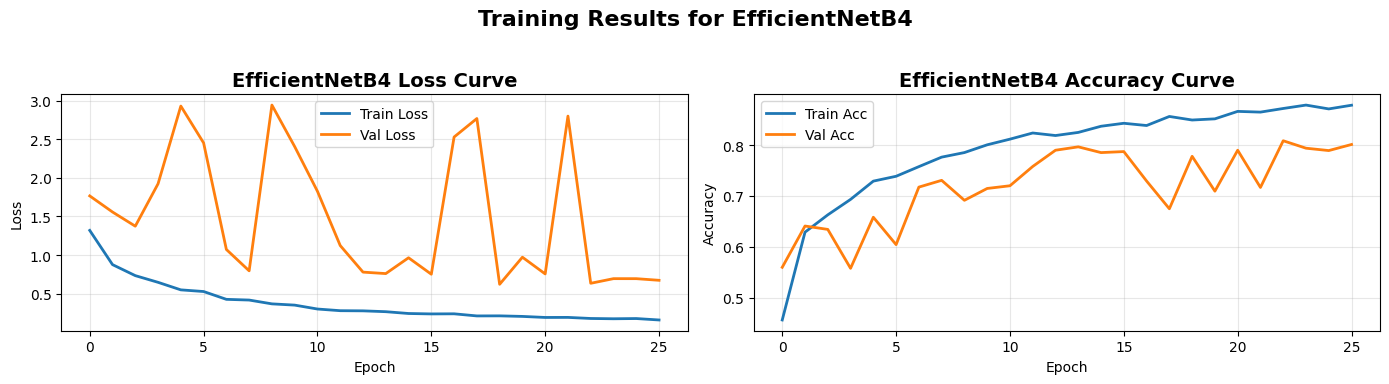

In [14]:
plot_model_history(all_histories['efficientnetb4'], model_name='EfficientNetB4')

### DenseNet201 Metrics

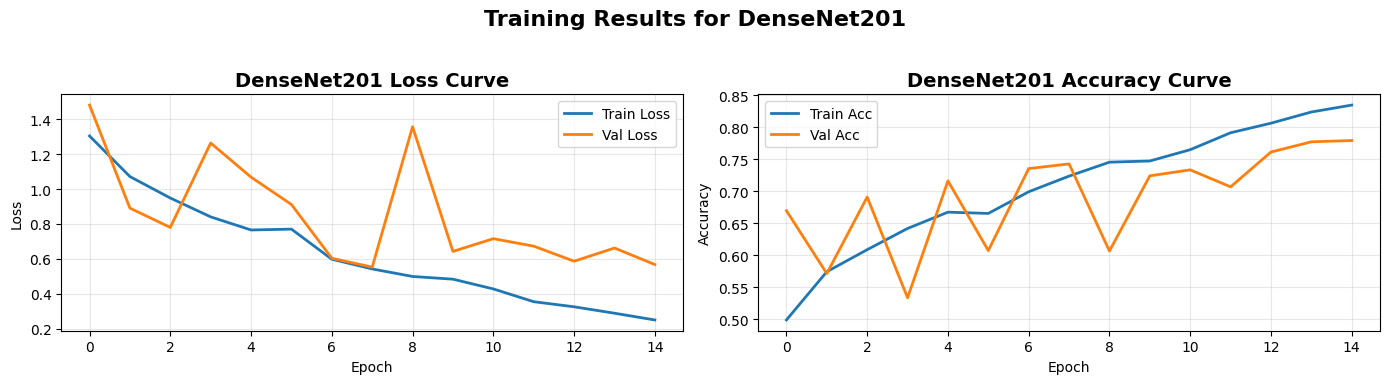

In [15]:
plot_model_history(all_histories['densenet201'], model_name='DenseNet201')

### ResNet101 Metrics

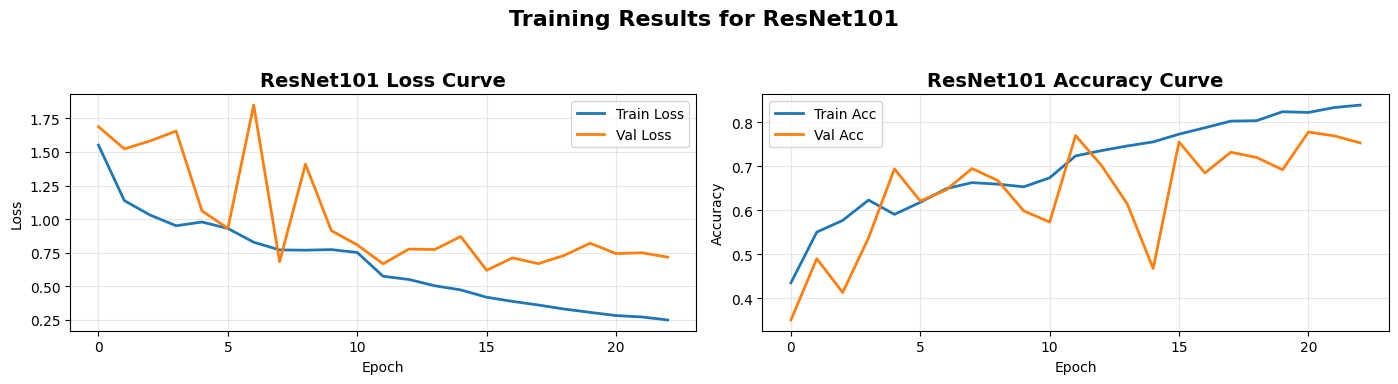

In [16]:
plot_model_history(all_histories['resnet101'], model_name='ResNet101')

### InceptionV3 Metrics

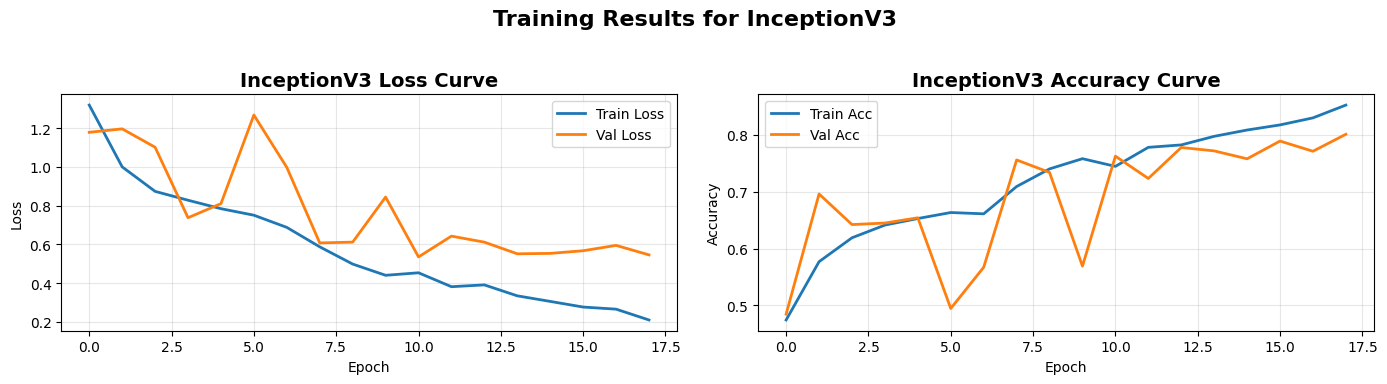

In [17]:
plot_model_history(all_histories['inceptionv3'], model_name='InceptionV3')

### Xception Metrics

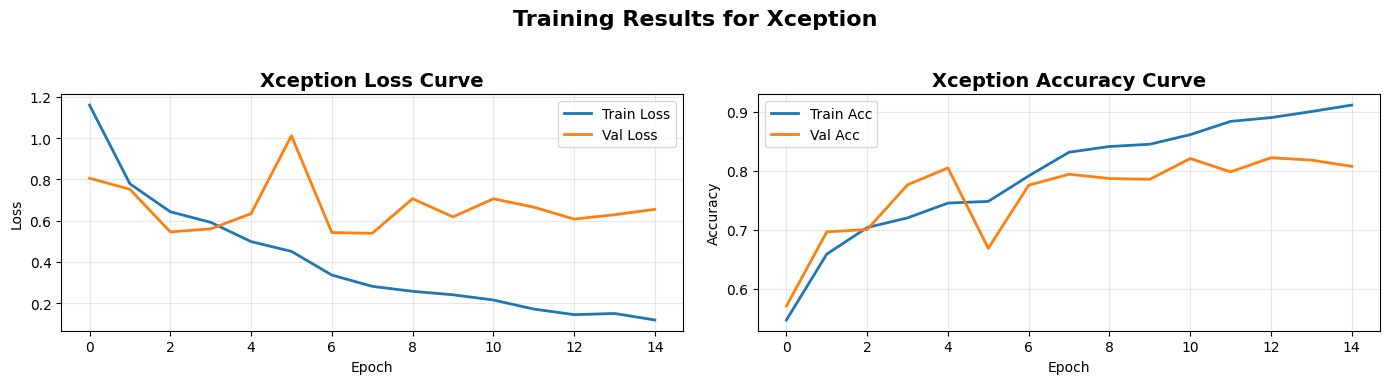

In [18]:
plot_model_history(all_histories['xception'], model_name='Xception')

## Save All Trained Models from Colab Local to Google Drive

In [20]:
import shutil

src_dir = '/content/models'
dst_dir = '/content/drive/MyDrive/Skin-Cancer-Detection/models'

os.makedirs(dst_dir, exist_ok=True)

for fname in os.listdir(src_dir):
    src_path = os.path.join(src_dir, fname)
    dst_path = os.path.join(dst_dir, fname)
    if os.path.isfile(src_path):
        shutil.copy2(src_path, dst_path)
        print(f"Copied {fname} to Google Drive.")

print("All models copied to Google Drive!")

Copied densenet201_best_model.keras to Google Drive.
Copied resnet101_best_model.keras to Google Drive.
Copied efficientnetb4_best_model.keras to Google Drive.
Copied inceptionv3_best_model.keras to Google Drive.
Copied xception_best_model.keras to Google Drive.
All models copied to Google Drive!
